# Example: Quantum Convolutional Neural Network

In this notebook we show how to use the `QCNN encoding circuit` for classification.

## Imports

In [29]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from squlearn.encoding_circuit.circuit_library.param_z_feature_map import ParamZFeatureMap
from squlearn.encoding_circuit.qcnn_encoding_circuit import QcnnEncodingCircuit
from squlearn.encoding_circuit.layered_encoding_circuit import LayeredEncodingCircuit
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam
from squlearn import Executor
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## `QCNN encoding circuit` Setup

We start by showing examples of how to build the QCNN. The first example is the most simple way. With the `default` keyword set to "True" the default circuit with the given number of qubits and features is build.

fit:  10%|█         | 1/10 [00:31<04:39, 31.10s/it]


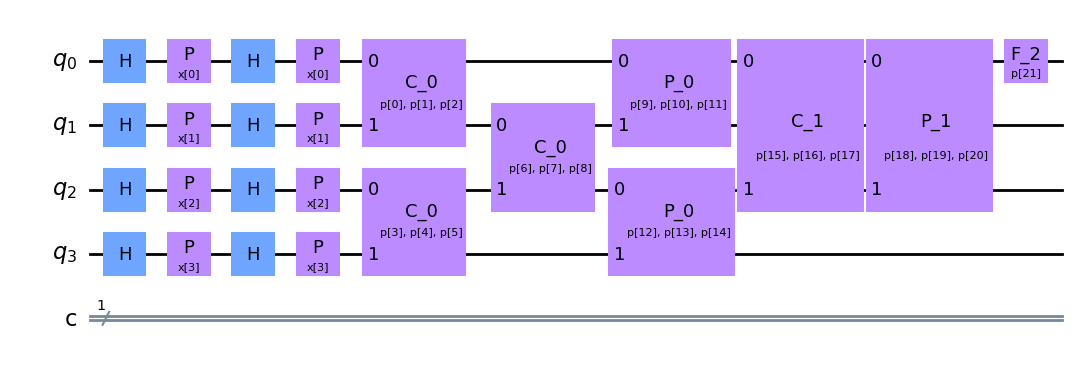

In [30]:
qc1 = QcnnEncodingCircuit(num_qubits=4,num_features=4,default=True)
qc1.draw("mpl")

Another fast way would be to define a convolution layer and a pooling layer and call the `repeat_layers` function to repeat the first layers until few enough qubits are left in the circuit. The individual building blocks can be resolved with the keyword `decompose`.

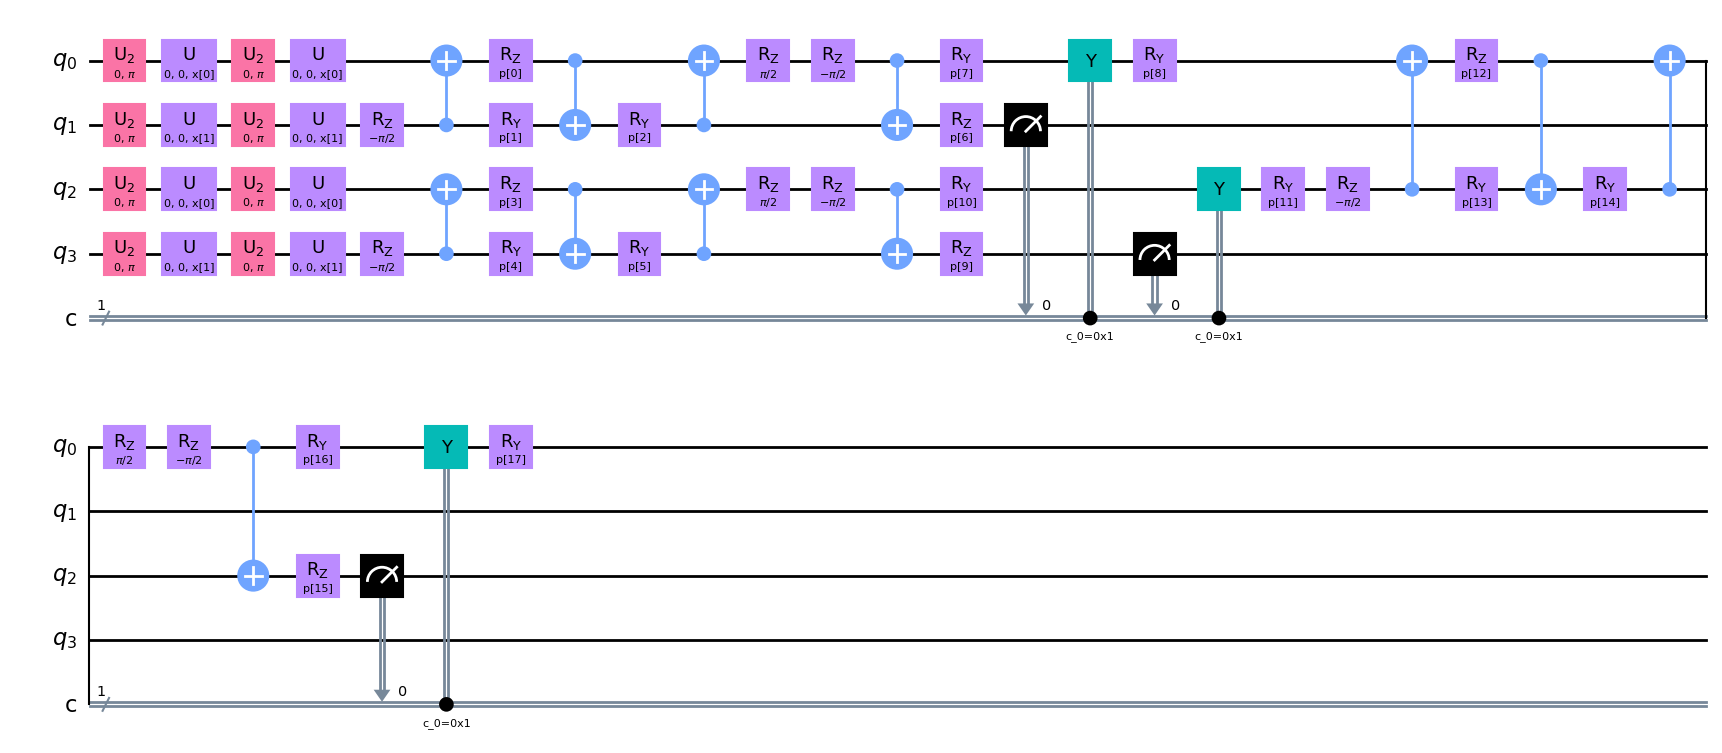

In [31]:
qc1 = QcnnEncodingCircuit(4,2)
qc1.convolution(alternating=False)
qc1.pooling(measurement=True)
qc1.repeat_layers()
qc1.draw("mpl", decompose=True)

We can provide our own feature map and add it in front of the encoding circuit. Notice that in the qcnn encoding circuit no number of features is handed over and therefore set to 0. Further we can change the number of qubits in the circuit on the fly `up` (and `down` if the applied pooling gates allow it).

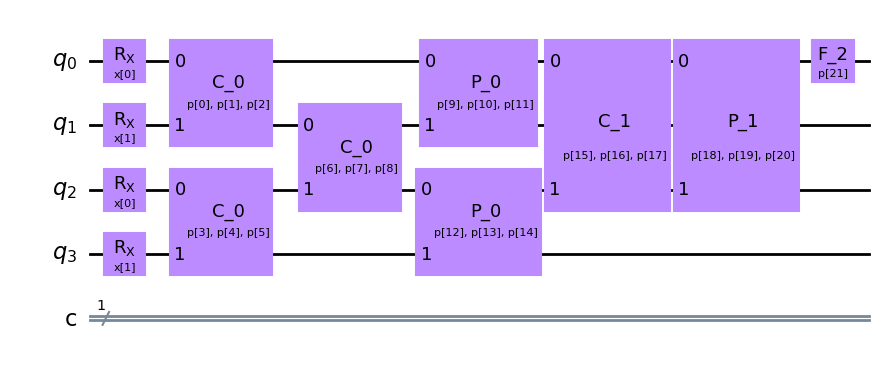

In [32]:
qc1 = QcnnEncodingCircuit(num_qubits=3,default=True)
qc1.set_num_qubits(4)
encode = LayeredEncodingCircuit.from_string("Rx(x)",num_qubits=4,num_features=2)
qcnn_pqc = encode + qc1
qcnn_pqc.draw("mpl")

We can overwrite the default circuits in the given layer by setting the keyword `QC`. The Circuits can either be `QuantumCircuit` or `sQUlearn circuit` objects (if one inputs a circuit with features as in "ParamZFeatureMap" a warning is shown). The circuit size is only restricted by the number of qubits left in the qcnn. In the pooling layer the adressed qubits can be set with the keywords `input_list` and `output_list`.

features parameters are set to 1 since no features are allowed in the QCNN ansatz.


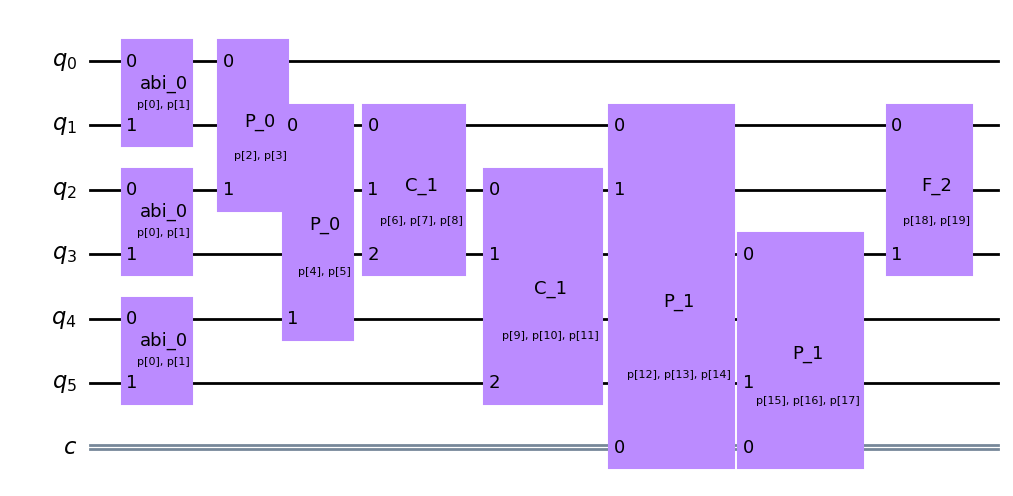

In [33]:
qc1 = QcnnEncodingCircuit(6)

qc2 = ParamZFeatureMap(2,2,1)

x1 = ParameterVector("x", 2)
qc3 = QuantumCircuit(2)
qc3.crx(x1[0],0,1)
qc3.rx(x1[1],0)

x2 = ParameterVector("x", 3)
qc4 = QuantumCircuit(3)
qc4.rx(x2[0],0)
qc4.rx(x2[1],1)
qc4.rx(x2[2],2)
qc4.cx(0,1)
qc4.cx(1,2)

qc1.convolution(QC=qc2, label = "abi", alternating=False, diff_params=False)
qc1.pooling(QC=qc3,input_list = [[0,2],[1,4]],output_list = [[2],[1]])
qc1.convolution(QC=qc4)
qc1.pooling(measurement=True)
qc1.fully_connected()
qc1.draw("mpl")

Finally we can build the circuit from the back by supplying the gates first and then how many qubits should be in the output and you can even continue building from there forward if no fully connected layer is applied.

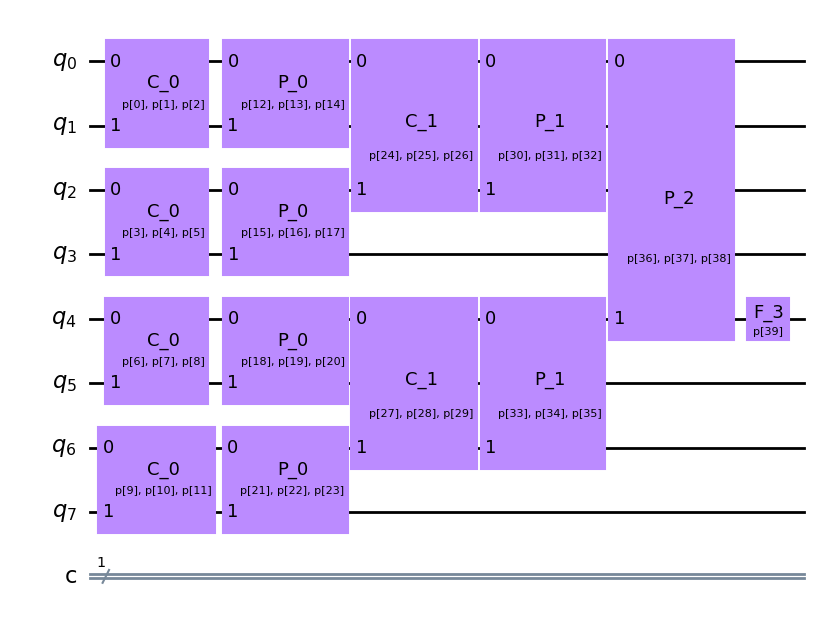

In [34]:
qc1 = QcnnEncodingCircuit()
qc1.convolution(alternating=False)
qc1.pooling()
qc1.repeat_layers(1)
qc1.build_circuit(2)
qc1.pooling(input_list = [[0,4]],output_list = [[4]])
qc1.fully_connected()
qc1.draw("mpl")

The fitting default observable for the circuit can be extracted once finished with building the circuit. Notice that the observable "IIIIIZ" corresponds to only measuring the first qubit "q0".

In [35]:
ob = qc1.QcnnObservable(pauli="Z")
print(ob)

SparsePauliOp(['IIIZIIII'],
              coeffs=[ParameterExpression(1.0*p[0])])


In the following we creat training and test data. This is not supposed to be a senceful usecase of qcnn structures but to show how to properly work with this encoding circuit in the sQUlearn environment.

In [36]:
# Data that is inputted to the QNN
X = np.arange(-0.5, 0.6, 0.1)
# Data that is fitted by the QNN
y = np.square(X)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=44
)

Next the encoding circuit and observable are build.

SparsePauliOp(['IIIZ'],
              coeffs=[ParameterExpression(1.0*p[0])])


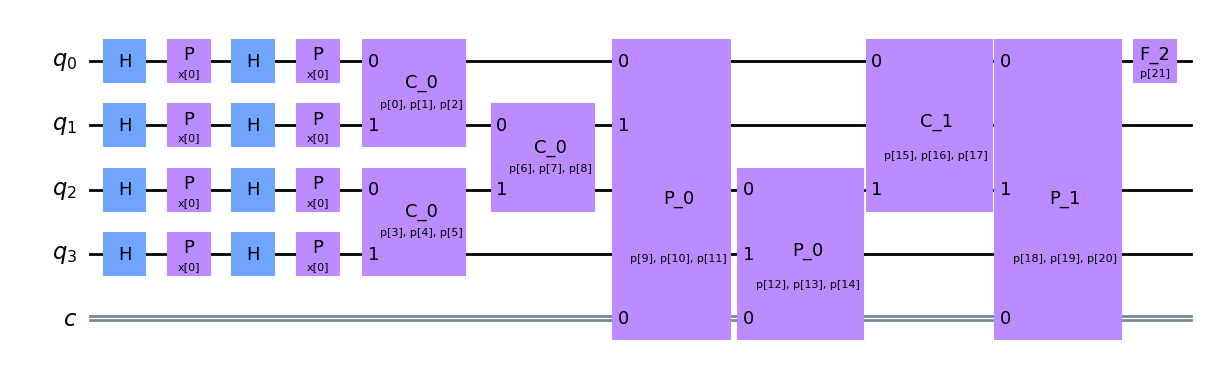

In [37]:
qc = QcnnEncodingCircuit(4,1)
qc.convolution()
qc.pooling(measurement=True)
qc.repeat_layers()
qc.fully_connected()

ob = qc.QcnnObservable()
print(ob)
qc.draw("mpl")


Now we can set up the Regressor and train it. Notice that if one sets `measurement` to "True", one needs to use a sampler executor like "qasm_simulator".

In [38]:
qnn = QNNRegressor(qc, ob, Executor("qasm_simulator"), SquaredLoss(), Adam(options={"maxiter":10}), param_ini=[ 1.40457803, 0.77573681, 0.82123314, -1.19685962, -0.75947028, 0.60125077, 0.00767134, 1.52627551, 2.97959987, 0.39335939, 2.18724314, -0.55584745, -0.74268985, 2.78973491, -2.81332345, -1.07928758, -3.0969078, 3.12181512, 1.76198676, 1.97996629, 3.07477509, 1.5617964], param_op_ini = [1.22629885], pretrained = True)
qnn.fit(X_train, y_train)

fit:   0%|          | 0/10 [00:00<?, ?it/s]

fit: 100%|██████████| 10/10 [01:07<00:00,  6.68s/it]

Finally we can plot the results of the classification.

[ 1.52789058  0.89134181  0.76649698 -1.50121638 -0.75114876  0.75089889
 -0.10965209  1.58603925  3.23369787  0.43068479  2.12343658 -0.72994654
 -0.83877339  2.77289147 -2.9351828  -0.99867323 -3.08996697  3.11055742
  1.87384317  2.14971549  3.05114058  1.52692914] [1.34468594]
sigma train:  0.09014818660220877 , sigma test:  0.09067484022468626


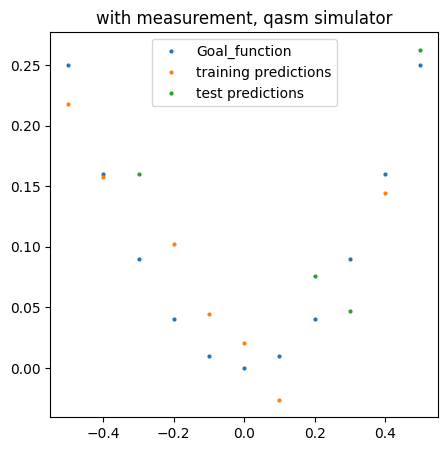

In [39]:
print(qnn.param,qnn.param_op)
y_train_predict = qnn.predict(X_train)
y_test_predict = qnn.predict(X_test)

fig, ax = plt.subplots(1, 1, figsize=(5,5))
ax.set_title("with measurement, qasm simulator")
ax.plot(X,y, label = "Goal_function", markersize = 2, marker='o', linestyle = "None")
ax.plot(X_train,y_train_predict, label = "training predictions", markersize = 2, marker='o', linestyle = "None")
ax.plot(X_test,y_test_predict, label = "test predictions", markersize = 2, marker='o', linestyle = "None")
ax.legend()

sigma_train = np.sqrt(np.sum(np.square(y_train_predict-y_train)))
sigma_test = np.sqrt(np.sum(np.square(y_test_predict-y_test)))
print("sigma train: ",sigma_train,", sigma test: ",sigma_test)